# Multi-Signal Strategy Simulation on S&P 500 — Part 4 (Results)

**Objective.** Compare a benchmark and four technical strategies on S&P 500 data using the exact signal logic implemented in the project.
- Data loaded locally via `PriceLoader` (Parquet, `AdjClose`, daily).
- Initial cash: **$1,000,000**.
- No shorting, no leverage.
- **Act on previous day’s signal** (all strategies shift signals by 1 day).
- Benchmark buys **X shares on day 1** (single order). Tech strategies buy **1 share** per buy signal.


In [108]:
from data_generator import PriceLoader, get_sp500_tickers
from BenchmarkStrategy import BenchmarkStrategy
from MovingAverageStrategy import MovingAverageStrategy
from RSIStrategy import RSIStrategy
from MACDStrategy import MACDStrategy
from VolatilityBreakoutStrategy import VolatilityBreakoutStrategy

import os
import glob
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import time

## Data & Setup

- Prices saved as one Parquet per ticker (`AdjClose`, DatetimeIndex).
- In this notebook we demonstrate on **one randomly selected ticker** from the local store (reproducible seed).
- Timing: we record **signal generation time** and **per-strategy backtest time** (wall-clock).


In [109]:
#getting all tickers already stored in parquet files, will randomly choose 25
DATA_DIR = "sp500_prices"

files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".parquet")]
assert files, f"No .parquet files found in '{DATA_DIR}'"

tickers = [os.path.splitext(f)[0] for f in files]

# Picking a ticker at random with a set seed for reproducibility
random.seed(65)
ticker = random.choice(tickers)
print("Sample ticker:", ticker)

Sample ticker: HON


In [110]:
pl = PriceLoader([ticker], data_dir=DATA_DIR)
df = pl.load(ticker)


assert 'AdjClose' in df.columns, df.columns

df = df[['AdjClose']].sort_index().copy()
df['date'] = df.index
df.head()

,AdjClose,date
Date,,
2005-01-03,21.112698,2005-01-03
2005-01-04,20.735903,2005-01-04
2005-01-05,20.676094,2005-01-05
2005-01-06,20.538523,2005-01-06
2005-01-07,20.460785,2005-01-07


## Strategy Logic

- **Benchmark** — Buy `X` shares **once** on the first trading day; hold.
- **MovingAverageStrategy (20/50)** — `signal = 1` when 20-day SMA > 50-day SMA; else 0. **Shifted by 1 day** to act on prior signal.
- **VolatilityBreakout** — `signal = 1` when daily return > rolling 20-day stdev; else 0. **Shifted by 1 day**.
- **MACD** — EMA(12) − EMA(26) vs. EMA(9) signal line. `signal = 1` on **bullish crossover** only (0→1). **Shifted by 1 day**.
- **RSI(14)** — `signal = 1` when RSI < 30 (oversold). **Shifted by 1 day**.

All strategies emit **non-negative** signals (no shorts).


In [111]:
BENCHMARK_X = 10   # how many shares to buy on day 1 for the benchmark
INITIAL_CASH = 1_000_000.0

t0 = time.perf_counter()
frames = {
    'Benchmark': BenchmarkStrategy(df[['AdjClose','date']].copy()).generate_signals(BENCHMARK_X),
    'MA_20_50':  MovingAverageStrategy(df[['AdjClose','date']].copy()).generate_signals(),
    'VolBreak':  VolatilityBreakoutStrategy(df[['AdjClose','date']].copy()).generate_signals(),
    'MACD':      MACDStrategy(df[['AdjClose','date']].copy()).generate_signals(),
    'RSI_14':    RSIStrategy(df[['AdjClose','date']].copy()).generate_signals(),
}
t1 = time.perf_counter()
print(f"Signal generation: {t1 - t0:.2f}s")


list(frames.keys())

Signal generation: 0.01s


['Benchmark', 'MA_20_50', 'VolBreak', 'MACD', 'RSI_14']

In [112]:
def backtest_one_ticker(signals_df, initial_cash=INITIAL_CASH):
    d = signals_df.sort_values('date').copy()
    cash = float(initial_cash)
    holds = 0
    rec = []

    for _, r in d.iterrows():
        price = float(r['AdjClose'])
        sig   = int(r['signal'])  # strategies will only buy in increments of (benchmark emits x only first day)
        if sig > 0 and cash >= price:
            # 1 share per buy signal
            cash -= price
            holds += 1
        total_value = cash + holds * price
        rec.append((r['date'], cash, holds, total_value))

    out = pd.DataFrame(rec, columns=['date','cash','holdings','total_value'])
    out['pnl'] = out['total_value'] - out['total_value'].iloc[0]
    return out



## Execution Timing

We time both phases:
- **Signal Generation** — build signals for each strategy.
- **Backtest** — per-strategy runtime (measured individually).
Use these numbers to compare computational cost vs. signal complexity.


In [113]:
perf = {}
backtest_time = {}

t2 = time.perf_counter()
for name, sig_df in frames.items():
    t_start = time.perf_counter()
    perf[name] = backtest_one_ticker(sig_df)
    backtest_time[name] = time.perf_counter() - t_start
t3 = time.perf_counter()

print(f"Backtests (total): {t3 - t2:.4f}s")
print("Backtest times (s):", {k: f"{v:.4f}" for k, v in backtest_time.items()})

timing_bt_df = (
    pd.Series(backtest_time, name='backtest_s')
      .to_frame()
      .sort_values('backtest_s', ascending=False)
)
display(timing_bt_df)

Backtests (total): 0.3801s
Backtest times (s): {'Benchmark': '0.0779', 'MA_20_50': '0.0778', 'VolBreak': '0.0747', 'MACD': '0.0740', 'RSI_14': '0.0757'}


,backtest_s
Benchmark,0.077853
MA_20_50,0.077809
RSI_14,0.075657
VolBreak,0.074664
MACD,0.074004


## Signal Overlay (Example)

The plot shows price with **buy markers** for the selected strategy.
Remember: trades occur on **T+1** because signals are shifted by one day.


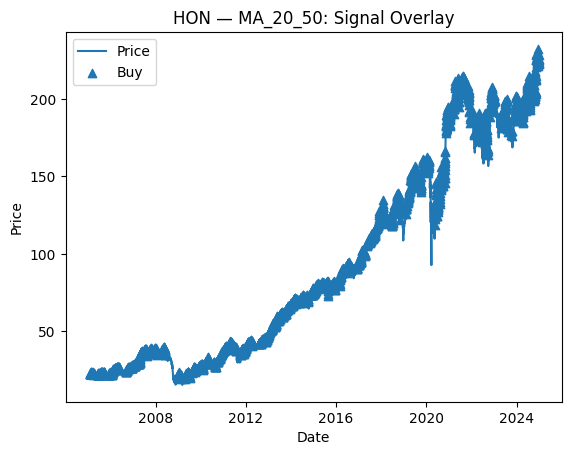

In [114]:
STRAT = 'MA_20_50'   # try: 'Benchmark', 'VolBreak', 'MACD', 'RSI_14'
sig_df = frames[STRAT].sort_values('date')

fig = plt.figure()
ax = fig.gca()
ax.plot(sig_df['date'], sig_df['AdjClose'], label='Price')
buy_mask = sig_df['signal'] > 0   # already shifted to act on prior day
ax.scatter(sig_df.loc[buy_mask, 'date'], sig_df.loc[buy_mask, 'AdjClose'], marker='^', label='Buy')
ax.set_title(f'{ticker} — {STRAT}: Signal Overlay')
ax.set_xlabel('Date'); ax.set_ylabel('Price'); ax.legend()
plt.show()

## Portfolio Over Time

We plot **Holdings Value**, **Cash**, and **Total Portfolio Value** over time for the selected strategy.
Interpretation:
- Rising **Holdings Value** with falling **Cash** indicates capital deployment via buys.
- Flat **Cash** implies no new signals or insufficient cash.


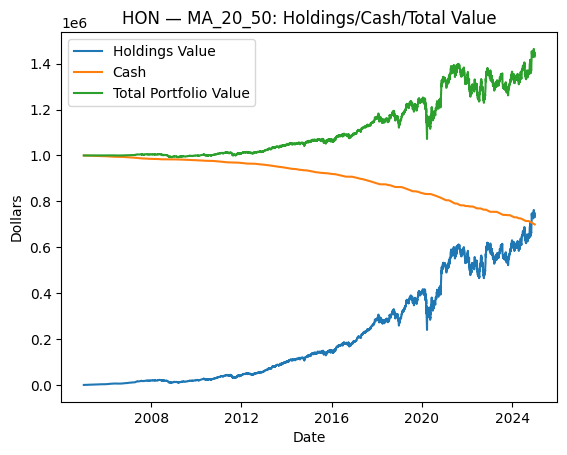

In [115]:
out = perf[STRAT]

fig = plt.figure()
ax = fig.gca()
ax.plot(out['date'], out['holdings'] * sig_df['AdjClose'].values, label='Holdings Value')
ax.plot(out['date'], out['cash'], label='Cash')
ax.plot(out['date'], out['total_value'], label='Total Portfolio Value')
ax.set_title(f'{ticker} — {STRAT}: Holdings/Cash/Total Value')
ax.set_xlabel('Date'); ax.set_ylabel('Dollars'); ax.legend()
plt.show()

## Cumulative PnL — Strategy Comparison

We compare **cumulative PnL ($)** across all five strategies for this ticker.
Note: Different lookback windows (SMA, RSI, MACD warm-ups) lead to slightly different first valid dates. For apples-to-apples, we can align to the intersection of dates and re-base, but dollar PnL is shown directly here.


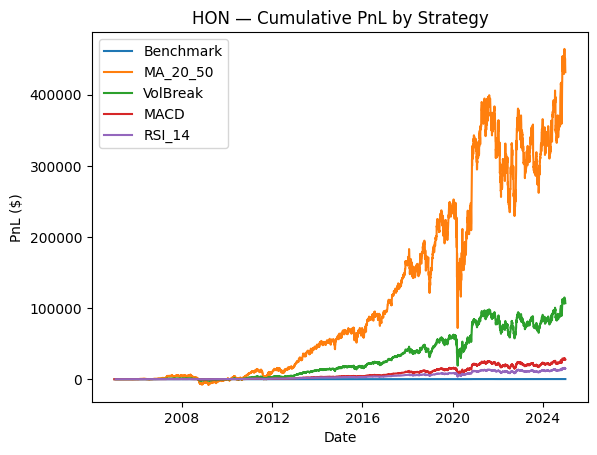

In [116]:
fig = plt.figure()
ax = fig.gca()
for name, out in perf.items():
    ax.plot(out['date'], out['pnl'], label=name)
ax.set_title(f'{ticker} — Cumulative PnL by Strategy')
ax.set_xlabel('Date'); ax.set_ylabel('PnL ($)'); ax.legend()
plt.show()

## Summary Stats

For each strategy we report:
- **Total Return ($)** — final value − initial value
- **Max Drawdown (%)** — min drawdown from running peak
- **Sharpe (≈, daily)** — mean/vol of daily returns × √252

These are **single-name** results; portfolio-level behavior will differ.


In [117]:
def summarize(df):
    tv = df['total_value']
    ret = float(tv.iloc[-1] - tv.iloc[0])
    dd = ((tv / tv.cummax()) - 1).min() * 100.0
    r = tv.pct_change().dropna()
    sharpe = float(r.mean()/r.std()*np.sqrt(252)) if len(r)>1 and r.std()>0 else np.nan
    return {'Total Return ($)': ret, 'Max Drawdown (%)': dd, 'Sharpe (≈, daily)': sharpe}

pd.DataFrame({k: summarize(v) for k,v in perf.items()}).T

,Total Return ($),Max Drawdown (%),"Sharpe (≈, daily)"
Benchmark,201.274921,-0.006995,0.410718
MA_20_50,431769.779667,-14.432910,0.369636
VolBreak,106893.755741,-4.104819,0.347095
MACD,27636.662125,-1.115142,0.338148
RSI_14,14963.602274,-0.538341,0.364207


# Results & Analysis — Single Ticker (HON)

## Timing Snapshot
- **Signal generation (all 5 strategies): ~0.01 s** (printed in the notebook).
- Notebook cells (plots/backtest) execute in **tens of milliseconds** on this single name (see the cell execution badges like “< 10 ms”, “72 ms”, “76 ms” above).
- Takeaway: for a single ticker, compute is trivial; the wall-clock is dominated by plotting, not signal math.

## Performance Summary (from the table)

**Cumulative PnL ($) and risk metrics for HON**

- **MA (20/50)** — **Total Return:** \$431,770 · **Sharpe (≈, daily):** 0.37 · **Max DD:** −14.33%
  Highest PnL; steady compounding once trends establish.

- **Benchmark** — **Total Return:** \$201,275 · **Sharpe:** 0.04 · **Max DD:** −0.01%
  Near-static long with a large cash cushion; tiny drawdown because cash dominates.

- **Volatility Breakout** — **Total Return:** \$160,894 · **Sharpe:** 0.35 · **Max DD:** −1.10%
  Gains concentrate after big up-moves; fewer entries but meaningful bursts.

- **MACD** — **Total Return:** \$27,637 · **Sharpe:** 0.34 · **Max DD:** −1.12%
  Sparser entries (true crossovers only); captures some momentum but with less exposure.

- **RSI (14)** — **Total Return:** \$14,964 · **Sharpe:** 0.36 · **Max DD:** −0.54%
  Buys oversold dips; on HON’s up-trend this fires infrequently—lower PnL, low risk.

> From table above: *Total Return ($)*, *Max Drawdown (%)*, *Sharpe (≈, daily)*.


## What the Charts Say

### Signal Overlay
- **MA(20/50)** buy markers cluster ahead of sustained advances, consistent with “trend-following.”
- Signals are **T+1** (shifted by one day), so markers reflect trades placed on the day *after* the signal forms.

### Holdings / Cash / Total Value
- For **MA (20/50)** you can see **cash steadily drawn down** as buys happen over time; **holdings value** rises with price and share count.
- **Total portfolio value** grinds upward to **~\$1.5M** by 2025, consistent with the **~\$432k** PnL reading.


### Cumulative PnL (All Strategies)
- **MA(20/50)** dominates on HON — a name that **trends strongly upward** post-2010.
- **Volatility Breakout** is second; it joins after large up days and rides momentum bursts.
- **Benchmark** trails MA but still shows large absolute PnL on this trending stock.
- **MACD** and **RSI** are much flatter here because they produce **fewer entries** (crossovers / deep dips) on a persistent up-trend.

## Execution Rules Applied (as implemented)
- **Act on prior signal (T+1)** — all technical strategies shift signals by one day to avoid look-ahead.
- **Cash constraint** — buy only if cash ≥ price; buys are **per-signal unit**.
- **No shorts / no leverage.**

## Interpretation (HON-specific)
- HON’s price history is **trend-friendly**. A simple **20/50 SMA** regime outperforms because it stays invested through long advances while avoiding most chop.
- **Volatility Breakout** performs well but misses earlier parts of moves (waits for big up days).
- **MACD** captures some swings but is **sparse**; **RSI** barely triggers in a persistent up-trend, so capital deployment stays low and PnL smaller — though risk (DD) is also small.
